# Phase 4 — Event-level evaluation + Multi-label training + Robustness package

Goal of Phase 4:
1) Convert your **pair-level** table into **event-level** predictions (no “multiple pairs per event” confusion)
2) Train and evaluate **multiple HLT labels** (1 model per label) with the SAME GroupKFold splits
3) Add robustness: calibration, threshold selection, drift vs run/lumi, and clean artifacts export

Input: `/kaggle/working/parquet_dimuon/*.parquet` (from Phase 2)

Output (saved to `/kaggle/working/phase4_artifacts/`):
- `metrics_per_label.csv` (pair-level + event-level)
- `thresholds.csv` (operating points)
- `models/` (joblib models per label)
- `plots/` (ROC/PR, stability, calibration)
- `config.json`


In [1]:
# Cell 1 — Install deps
!pip -q install lightgbm scikit-learn shap pyarrow fastparquet matplotlib seaborn joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.6 MB/s eta 0:00:0000:010:01


In [2]:
# Cell 2 — Imports & config
from pathlib import Path
import glob, json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
import lightgbm as lgb
import joblib

SEED = 42
np.random.seed(SEED)

PARQUET_DIR = Path("/kaggle/input/datasets/katakuricharlotte/parquet-triggeremu/parquet_dimuon")
OUT = Path("/kaggle/working/phase4_artifacts")
(OUT / "models").mkdir(parents=True, exist_ok=True)
(OUT / "plots").mkdir(parents=True, exist_ok=True)

parquet_files = sorted(glob.glob(str(PARQUET_DIR / "*.parquet")))
len(parquet_files), parquet_files[:3]


(1,
 ['/kaggle/input/datasets/katakuricharlotte/parquet-triggeremu/parquet_dimuon/dimuon_shard_000.parquet'])

In [3]:
# Cell 3 — Load Parquet (scale-friendly)
# Start with all shards; if too big, cap MAX_FILES.
MAX_FILES = None  # set e.g. 5 if you want faster iteration
use_files = parquet_files if MAX_FILES is None else parquet_files[:MAX_FILES]

df = pd.concat([pd.read_parquet(p) for p in use_files], ignore_index=True)
df.shape, df.head(3)


((1378545, 12),
       run  lumi       event     m_mumu    pt_mumu  eta_mumu   dR_mumu  \
 0  278822   951  1657783742   0.717688  27.446304  0.381257  0.051071   
 1  278822   951  1657783742  17.536045   5.466623  1.782907  3.233651   
 2  278822   951  1658163927   0.328497  31.051395 -1.633330  0.008130   
 
    PV_npvs     MET_pt  HLT_Mu17_Mu8  HLT_Mu17_Mu8_DZ  \
 0       12  27.271524             0                0   
 1       12  27.271524             0                0   
 2       10  24.150330             0                0   
 
    HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ  
 0                                    0  
 1                                    0  
 2                                    1  )

In [4]:
# Cell 4 — Basic data validation
required_cols = {"run","lumi","event"}
assert required_cols.issubset(df.columns), f"Missing keys: {required_cols - set(df.columns)}"

LABELS = sorted([c for c in df.columns if c.startswith("HLT_")])
assert len(LABELS) > 0, "No HLT labels found."

# event_id for grouping
df["event_id"] = df["run"].astype(str) + ":" + df["lumi"].astype(str) + ":" + df["event"].astype(str)

print("rows:", len(df))
print("unique events:", df["event_id"].nunique())
print("labels:", LABELS[:5], "... total:", len(LABELS))

(df[LABELS].mean().sort_values(ascending=False).head(10))


rows: 1378545
unique events: 1171442
labels: ['HLT_Mu17_Mu8', 'HLT_Mu17_Mu8_DZ', 'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'] ... total: 3


HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ    0.452260
HLT_Mu17_Mu8                           0.023145
HLT_Mu17_Mu8_DZ                        0.020059
dtype: float64

## Phase 4-A: Define features (explainable & stable)

We keep features that are:
- physically meaningful (m_mumu, pt_mumu, dR, etc.)
- simple context (PV_npvs, MET_pt)
No IDs and no HLT columns.


In [5]:
# Cell 5 — Feature set and simple preprocessing
drop_cols = set(["run","lumi","event","event_id"]) | set(LABELS)
features = [c for c in df.columns if c not in drop_cols]

X = df[features].copy()
for c in X.columns:
    if X[c].dtype == "object":
        X[c] = pd.to_numeric(X[c], errors="coerce")

# Simple median fill for baseline robustness
X = X.fillna(X.median(numeric_only=True))

X.shape, features


((1378545, 6),
 ['m_mumu', 'pt_mumu', 'eta_mumu', 'dR_mumu', 'PV_npvs', 'MET_pt'])

In [6]:
# Cell 6 — Utility: metrics at pair-level and event-level
def safe_auc(y_true, y_score):
    # Handle edge case where a fold has only one class
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_score)

def compute_metrics(y_true, y_score):
    return {
        "roc_auc": safe_auc(y_true, y_score),
        "ap": average_precision_score(y_true, y_score),
        "brier": brier_score_loss(y_true, y_score),
        "pos_rate": float(np.mean(y_true)),
        "n": int(len(y_true)),
    }

def event_level_aggregate(df_part, score_col="score", label_col="y"):
    # Aggregate pair rows to event-level:
    # - event score = max(score) (if any pair "looks like" it should fire, event fires)
    # - event label = max(label) (event-level label repeated, so max is safe)
    g = df_part.groupby("event_id", as_index=False).agg(
        y=(label_col, "max"),
        score=(score_col, "max"),
        run=("run", "first"),
        lumi=("lumi", "first"),
        event=("event", "first"),
    )
    return g


## Phase 4-B: Consistent GroupKFold splits (by event)

We split by `event_id` so that the same collision event never appears in both train and validation.


In [7]:
# Cell 7 — Prepare GroupKFold splits on unique events (stronger than splitting pair rows)
events_unique = df[["event_id"]].drop_duplicates().reset_index(drop=True)
event_ids = events_unique["event_id"].values

gkf = GroupKFold(n_splits=5)

splits = list(gkf.split(event_ids, np.zeros(len(event_ids)), groups=event_ids))
len(splits), [ (len(tr), len(va)) for tr,va in splits ]


(5,
 [(937153, 234289),
  (937153, 234289),
  (937154, 234288),
  (937154, 234288),
  (937154, 234288)])

In [8]:
# Cell 8 — Map event splits to pair-row indices (so training uses pair rows but validation stays event-disjoint)
event_to_fold = {}
for fold, (_, va_idx) in enumerate(splits, start=1):
    for eid in event_ids[va_idx]:
        event_to_fold[eid] = fold

df["fold"] = df["event_id"].map(event_to_fold).astype(int)
df["fold"].value_counts().sort_index()


fold
1    275842
2    275929
3    275602
4    275834
5    275338
Name: count, dtype: int64

## Phase 4-C: Train 1 model per label (with class imbalance handling)

We train LightGBM models with `scale_pos_weight` for imbalance, and we store:
- per-fold metrics
- overall OOF predictions
- event-level metrics after aggregating pair scores to event scores


In [9]:
# Cell 9 — Training loop for multiple labels
params = dict(
    n_estimators=800,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    n_jobs=-1,
)

all_metrics = []
oof_scores = {}   # label -> oof scores (pair-level)
models = {}

for label in LABELS:
    y = df[label].astype(int).values

    # Skip degenerate labels
    if y.mean() < 1e-4 or y.mean() > 1 - 1e-4:
        all_metrics.append({"label": label, "note": "skipped_degenerate", "pos_rate": float(y.mean())})
        continue

    oof = np.zeros(len(df), dtype=float)

    for fold in sorted(df["fold"].unique()):
        tr_mask = df["fold"].values != fold
        va_mask = df["fold"].values == fold

        X_tr, X_va = X.loc[tr_mask], X.loc[va_mask]
        y_tr, y_va = y[tr_mask], y[va_mask]

        pos = max(y_tr.sum(), 1)
        neg = max(len(y_tr) - y_tr.sum(), 1)
        spw = neg / pos

        clf = lgb.LGBMClassifier(objective="binary", scale_pos_weight=spw, **params)
        clf.fit(X_tr, y_tr)

        pred = clf.predict_proba(X_va)[:, 1]
        oof[va_mask] = pred

        m_pair = compute_metrics(y_va, pred)
        all_metrics.append({
            "label": label,
            "fold": int(fold),
            "level": "pair",
            "scale_pos_weight": float(spw),
            **m_pair
        })

    # Store OOF
    oof_scores[label] = oof

    # Train final model on all data
    pos = max(y.sum(), 1)
    neg = max(len(y) - y.sum(), 1)
    spw = neg / pos
    final_model = lgb.LGBMClassifier(objective="binary", scale_pos_weight=spw, **params)
    final_model.fit(X, y)

    models[label] = final_model
    joblib.dump(final_model, OUT / "models" / f"{label}.joblib")

len(models), list(models.keys())[:5]


[LightGBM] [Info] Number of positive: 25391, number of negative: 1077312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 1102703, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.023026 -> initscore=-3.747830
[LightGBM] [Info] Start training from score -3.747830
[LightGBM] [Info] Number of positive: 25554, number of negative: 1077062
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 1102616, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.023176 -> initscore=-3.741

(3, ['HLT_Mu17_Mu8', 'HLT_Mu17_Mu8_DZ', 'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'])

In [10]:
# Cell 10 — Compute event-level metrics from OOF (per label)
event_metrics = []

for label, oof in oof_scores.items():
    tmp = df[["event_id","run","lumi","event"]].copy()
    tmp["y"] = df[label].astype(int).values
    tmp["score"] = oof

    ev = event_level_aggregate(tmp, score_col="score", label_col="y")
    m_ev = compute_metrics(ev["y"].values, ev["score"].values)

    event_metrics.append({"label": label, "level": "event", "fold": "OOF", **m_ev})

event_metrics_df = pd.DataFrame(event_metrics).sort_values(["ap"], ascending=False)
event_metrics_df.head(15)


,label,level,fold,roc_auc,ap,brier,pos_rate,n
2,HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ,event,OOF,0.854013,0.821139,0.156055,0.498980,1171442
0,HLT_Mu17_Mu8,event,OOF,0.641999,0.040802,0.235345,0.024772,1171442
1,HLT_Mu17_Mu8_DZ,event,OOF,0.655972,0.036737,0.233206,0.021538,1171442


In [11]:
# Cell 11 — Combine and save metrics
metrics_df = pd.DataFrame(all_metrics)
metrics_out = OUT / "metrics_per_label.csv"
metrics_df.to_csv(metrics_out, index=False)

event_out = OUT / "event_metrics_oof.csv"
event_metrics_df.to_csv(event_out, index=False)

metrics_out, event_out


(PosixPath('/kaggle/working/phase4_artifacts/metrics_per_label.csv'),
 PosixPath('/kaggle/working/phase4_artifacts/event_metrics_oof.csv'))

## Phase 4-D: Choose operating thresholds (engineering deliverable)

We pick a threshold for each label based on a target **recall** (efficiency) or based on maximizing F1.
This makes the model usable like a trigger/selection component.


In [12]:
# Cell 12 — Threshold selection (OOF) per label (FIXED)

def choose_threshold(y_true, y_score, target_recall=0.95):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    idx = np.where(rec[:-1] >= target_recall)[0]
    if len(idx) == 0:
        f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
        best = np.nanargmax(f1)
        # thr has length len(prec)-1; protect index
        j = max(best - 1, 0)
        return float(thr[j]), float(prec[best]), float(rec[best])
    i = idx[0]
    return float(thr[i]), float(prec[i]), float(rec[i])

threshold_rows = []

for label, oof in oof_scores.items():
    # IMPORTANT: include run/lumi/event because event_level_aggregate expects them
    tmp = df[["event_id", "run", "lumi", "event"]].copy()
    tmp["y"] = df[label].astype(int).values
    tmp["score"] = oof

    ev = event_level_aggregate(tmp, score_col="score", label_col="y")

    th, p, r = choose_threshold(
        ev["y"].values,
        ev["score"].values,
        target_recall=0.95
    )

    threshold_rows.append({
        "label": label,
        "threshold": th,
        "precision_at_th": p,
        "recall_at_th": r,
        "event_pos_rate": float(ev["y"].mean()),
        "n_events": int(len(ev))
    })

thresholds_df = (
    pd.DataFrame(threshold_rows)
      .sort_values("event_pos_rate", ascending=False)
      .reset_index(drop=True)
)

thresholds_df


,label,threshold,precision_at_th,recall_at_th,event_pos_rate,n_events
0,HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ,0.001205,0.498980,1.0,0.498980,1171442
1,HLT_Mu17_Mu8,0.000812,0.024772,1.0,0.024772,1171442
2,HLT_Mu17_Mu8_DZ,0.000107,0.021538,1.0,0.021538,1171442


In [13]:
# Cell 13 — Save thresholds
thr_out = OUT / "thresholds.csv"
thresholds_df.to_csv(thr_out, index=False)
thr_out


PosixPath('/kaggle/working/phase4_artifacts/thresholds.csv')

## Phase 4-E: Plots (ROC/PR + calibration) for top labels
We generate plots for the top 3 labels by event-level AP (OOF).


In [14]:
# Cell 14 — Plot helpers
def save_roc_pr(y_true, y_score, title, out_prefix):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],"--",alpha=0.5)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"ROC: {title}")
    plt.tight_layout()
    plt.savefig(out_prefix + "_roc.png", dpi=150)
    plt.show()

    plt.figure(figsize=(6,5))
    plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"PR: {title}")
    plt.tight_layout()
    plt.savefig(out_prefix + "_pr.png", dpi=150)
    plt.show()

def save_calibration(y_true, y_score, title, out_prefix):
    frac_pos, mean_pred = calibration_curve(y_true, y_score, n_bins=10, strategy="quantile")
    plt.figure(figsize=(6,5))
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0,1],[0,1],"--",alpha=0.5)
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration: {title}")
    plt.tight_layout()
    plt.savefig(out_prefix + "_cal.png", dpi=150)
    plt.show()


In [15]:
# Cell 15 — Generate plots for top labels
top_labels = event_metrics_df.sort_values("ap", ascending=False)["label"].head(3).tolist()
top_labels


['HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ', 'HLT_Mu17_Mu8', 'HLT_Mu17_Mu8_DZ']

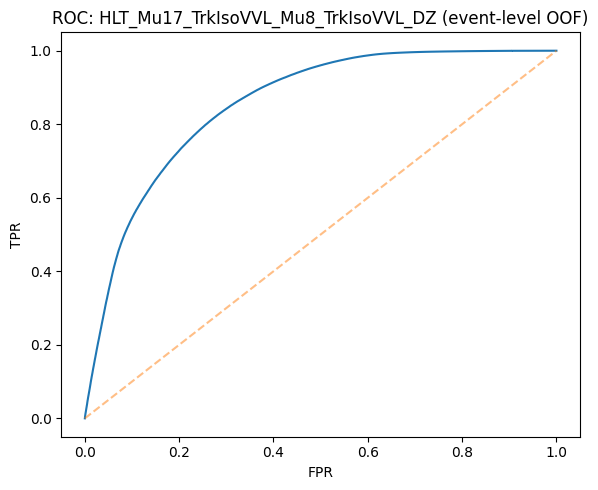

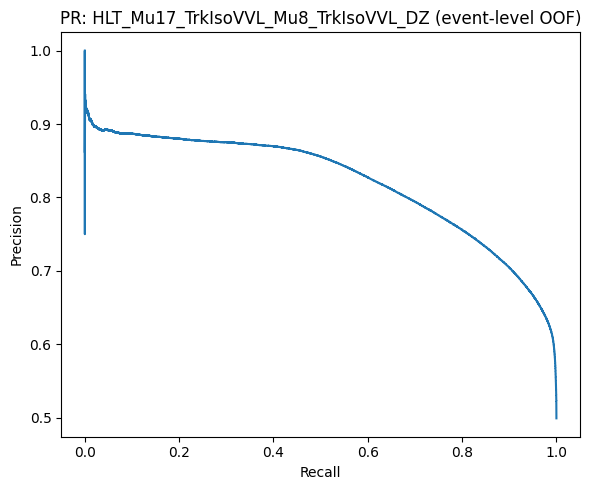

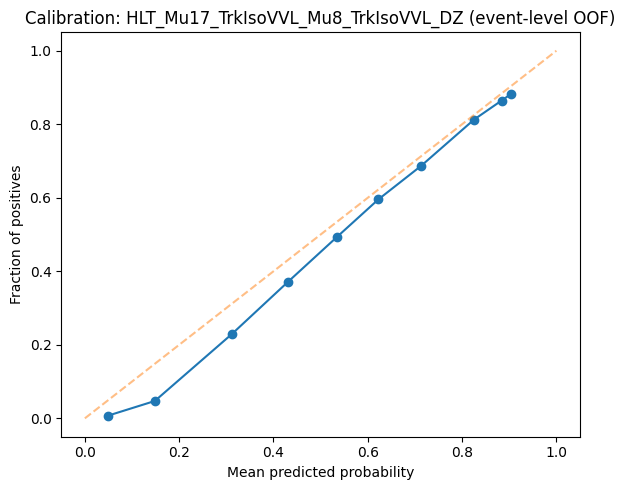

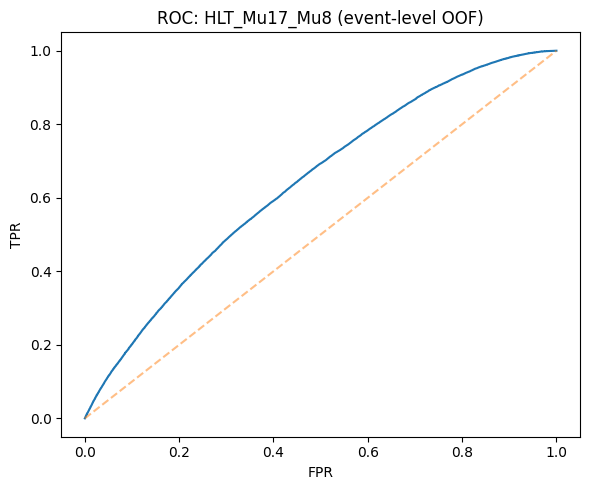

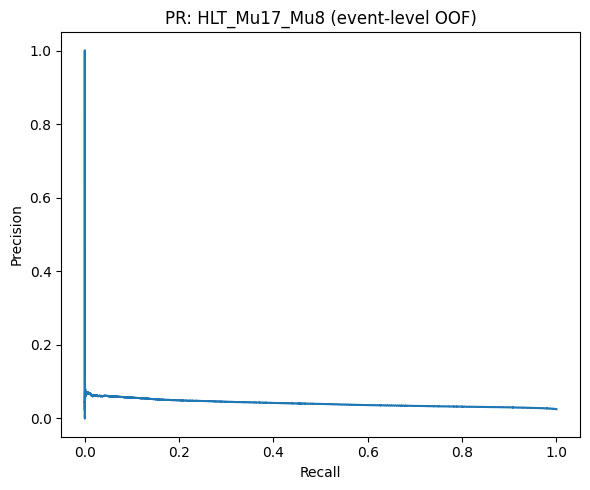

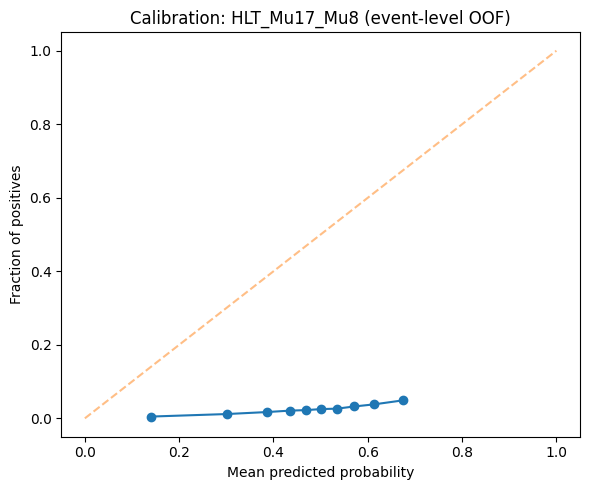

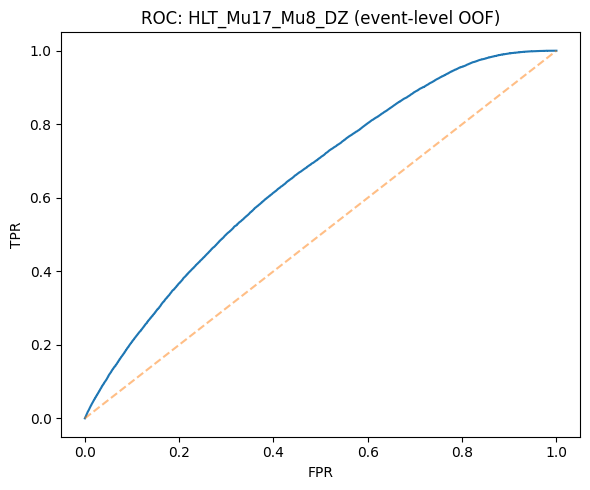

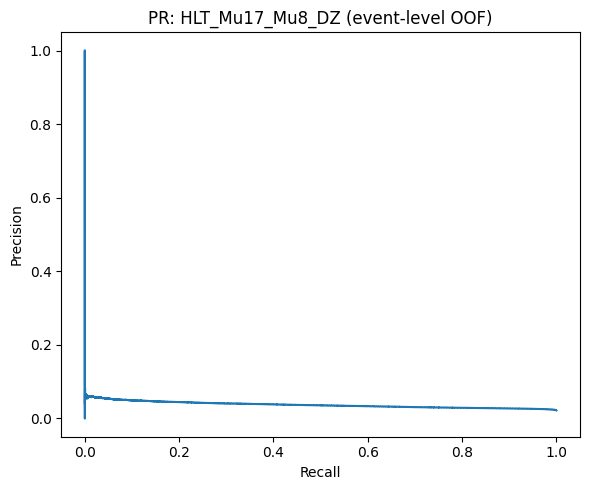

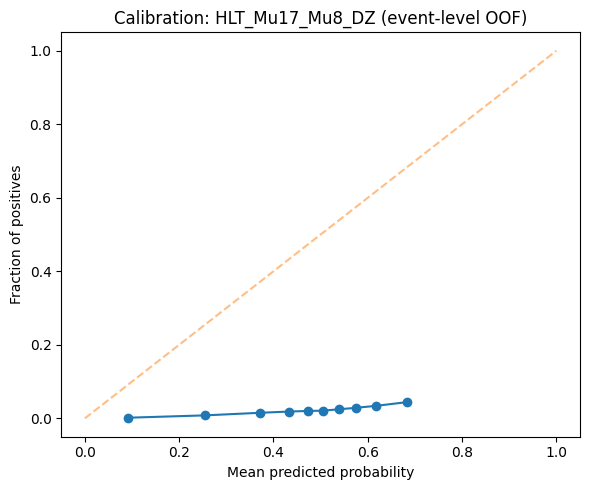

In [16]:
# Cell 16 — Plot OOF event-level ROC/PR/Calibration for top labels (FIXED)

for label in top_labels:
    oof = oof_scores[label]

    # IMPORTANT: include run/lumi/event because event_level_aggregate expects them
    tmp = df[["event_id", "run", "lumi", "event"]].copy()
    tmp["y"] = df[label].astype(int).values
    tmp["score"] = oof

    ev = event_level_aggregate(tmp, score_col="score", label_col="y")

    title = f"{label} (event-level OOF)"
    safe_name = label.replace("/", "_")
    out_prefix = str(OUT / "plots" / safe_name)

    save_roc_pr(ev["y"].values, ev["score"].values, title, out_prefix)
    save_calibration(ev["y"].values, ev["score"].values, title, out_prefix)


## Phase 4-F: Drift monitoring (event-level) vs run and lumi
We look at:
- label rate vs run bin
- mean score vs run bin

(You can later add lumi-level or time-ordered drift tests.)


In [17]:
# Cell 17 — Drift table & plots for the main label (best AP)
main_label = top_labels[0]
oof = oof_scores[main_label]

tmp = df[["event_id","run","lumi","event"]].copy()
tmp["y"] = df[main_label].astype(int).values
tmp["score"] = oof
ev = event_level_aggregate(tmp, score_col="score", label_col="y")

ev["run_bin"] = pd.cut(ev["run"], bins=10)

stab = ev.groupby("run_bin").agg(
    n=("y","size"),
    y_rate=("y","mean"),
    score_mean=("score","mean")
).reset_index()

stab


/tmp/ipykernel_55/723171339.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stab = ev.groupby("run_bin").agg(


,run_bin,n,y_rate,score_mean
0,"(278820.628, 278959.2]",198572,0.494042,0.538578
1,"(278959.2, 279096.4]",100528,0.497563,0.541869
2,"(279096.4, 279233.6]",40409,0.513475,0.550714
3,"(279233.6, 279370.8]",0,NaN,NaN
4,"(279370.8, 279508.0]",8462,0.446467,0.497104
5,"(279508.0, 279645.2]",58556,0.503706,0.546513
6,"(279645.2, 279782.4]",380022,0.502352,0.546005
7,"(279782.4, 279919.6]",130580,0.495336,0.532905
8,"(279919.6, 280056.8]",144118,0.493443,0.540885
9,"(280056.8, 280194.0]",110195,0.505304,0.546370


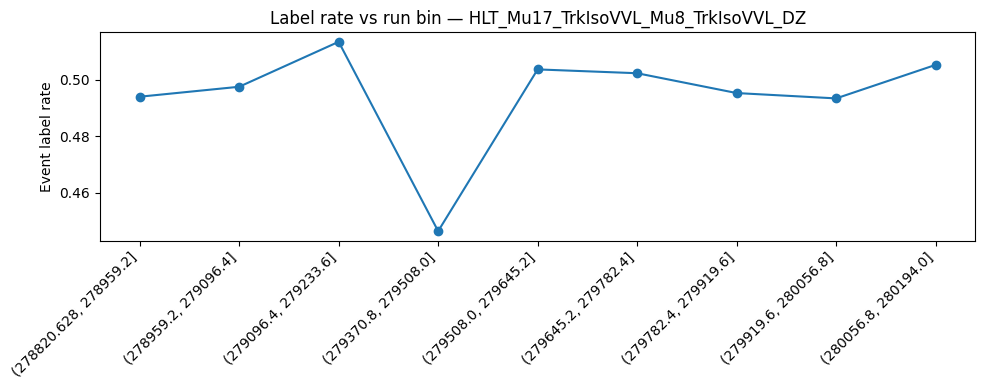

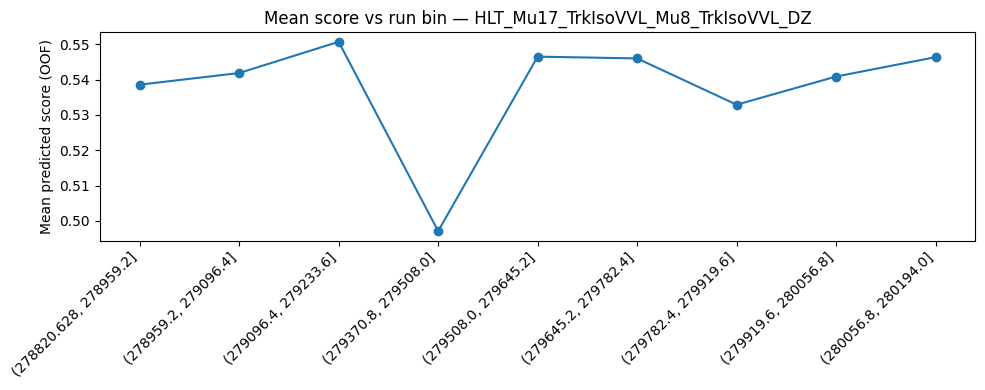

In [18]:
# Cell 18 — Plot drift vs run bins (drop empty bins)
stab2 = stab[stab["n"] > 0].copy()

plt.figure(figsize=(10,4))
plt.plot(stab2["run_bin"].astype(str), stab2["y_rate"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Event label rate")
plt.title(f"Label rate vs run bin — {main_label}")
plt.tight_layout()
plt.savefig(OUT / "plots" / f"{main_label}_drift_labelrate.png", dpi=150)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(stab2["run_bin"].astype(str), stab2["score_mean"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean predicted score (OOF)")
plt.title(f"Mean score vs run bin — {main_label}")
plt.tight_layout()
plt.savefig(OUT / "plots" / f"{main_label}_drift_score.png", dpi=150)
plt.show()


## Phase 4-G: Robust SHAP cell (no confusing warnings)

SHAP output shapes can differ for LightGBM binary classification (sometimes list, sometimes array),
so we handle both safely before plotting.


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/tmp/ipykernel_55/372408430.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv_use, X_s, show=False)


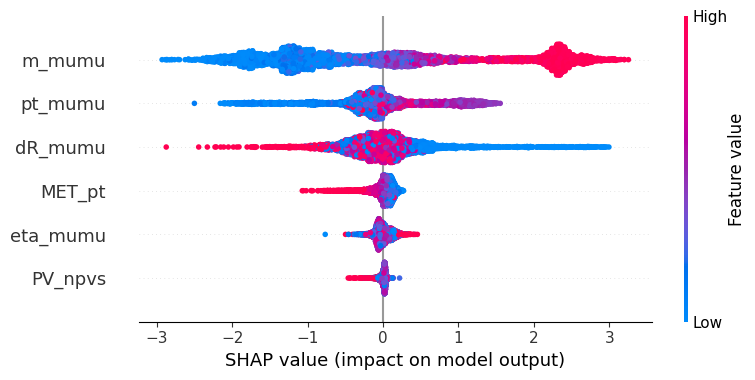

In [19]:
# Cell 19 — SHAP (safe handling)
import shap

label = main_label
model = models[label]

# Use a small sample of rows for speed
sample_n = min(5000, len(X))
idx = np.random.choice(len(X), sample_n, replace=False)
X_s = X.iloc[idx]

explainer = shap.TreeExplainer(model)
sv = explainer.shap_values(X_s)

# Some versions return list for binary class; take the positive-class component if needed. [web:159]
if isinstance(sv, list) and len(sv) == 2:
    sv_use = sv[1]
else:
    sv_use = sv

shap.summary_plot(sv_use, X_s, show=False)
plt.tight_layout()
plt.savefig(OUT / "plots" / f"{label}_shap_summary.png", dpi=150)
plt.show()


In [20]:
# Cell 20 — Save config + final directory listing
config = {
    "seed": SEED,
    "n_rows": int(len(df)),
    "n_unique_events": int(df["event_id"].nunique()),
    "features": list(X.columns),
    "labels_trained": list(models.keys()),
    "top_labels_by_event_ap": top_labels
}
with open(OUT / "config.json", "w") as f:
    json.dump(config, f, indent=2)

sorted([p.name for p in OUT.iterdir()]), sorted([p.name for p in (OUT/"plots").iterdir()])[:10]


(['config.json',
  'event_metrics_oof.csv',
  'metrics_per_label.csv',
  'models',
  'plots',
  'thresholds.csv'],
 ['HLT_Mu17_Mu8_DZ_cal.png',
  'HLT_Mu17_Mu8_DZ_pr.png',
  'HLT_Mu17_Mu8_DZ_roc.png',
  'HLT_Mu17_Mu8_cal.png',
  'HLT_Mu17_Mu8_pr.png',
  'HLT_Mu17_Mu8_roc.png',
  'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_cal.png',
  'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_drift_labelrate.png',
  'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_drift_score.png',
  'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_pr.png'])

In [21]:
import os, glob
base = "/kaggle/working/phase4_artifacts"
print("CSVs:", glob.glob(base + "/*.csv"))
print("Config:", glob.glob(base + "/*.json"))
print("Models:", glob.glob(base + "/models/*.joblib")[:5], "…")
print("Plots:", glob.glob(base + "/plots/*.png")[:5], "…")


CSVs: ['/kaggle/working/phase4_artifacts/event_metrics_oof.csv', '/kaggle/working/phase4_artifacts/metrics_per_label.csv', '/kaggle/working/phase4_artifacts/thresholds.csv']
Config: ['/kaggle/working/phase4_artifacts/config.json']
Models: ['/kaggle/working/phase4_artifacts/models/HLT_Mu17_Mu8_DZ.joblib', '/kaggle/working/phase4_artifacts/models/HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ.joblib', '/kaggle/working/phase4_artifacts/models/HLT_Mu17_Mu8.joblib'] …
Plots: ['/kaggle/working/phase4_artifacts/plots/HLT_Mu17_Mu8_cal.png', '/kaggle/working/phase4_artifacts/plots/HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_shap_summary.png', '/kaggle/working/phase4_artifacts/plots/HLT_Mu17_Mu8_DZ_cal.png', '/kaggle/working/phase4_artifacts/plots/HLT_Mu17_Mu8_pr.png', '/kaggle/working/phase4_artifacts/plots/HLT_Mu17_Mu8_DZ_pr.png'] …


# summary

- Multi-label models saved under `phase4_artifacts/models/`
- Pair-level CV metrics and event-level OOF metrics (`metrics_per_label.csv`, `event_metrics_oof.csv`)
- Operating thresholds (`thresholds.csv`)
- ROC/PR/Calibration/Drift plots for top labels
- SHAP explanation plot for the main label
